In [1]:
from pprint import pprint
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 144
import itertools as it
from functools import reduce
import operator as op
import numpy as np

In [2]:
import sys
(sys.version, pd.__version__, sns.__version__, plt.matplotlib.__version__, np.__version__)

('3.8.8 (default, Apr 13 2021, 19:58:26) \n[GCC 7.3.0]',
 '1.2.4',
 '0.11.1',
 '3.3.4',
 '1.20.1')

In [3]:
with open('dat/rates/SectorEcondAsicTestStatsPD_2.txt') as f:
    print(f.read())

 1  3  2  0 F      155.139      13.4736      151.878    148  5
 1  2  1  0 d      109.195      13.9637      107.495    108  3
 1  4  3  0 F      83.5257      5.64959      96.1745     93  3
 1  1  3  0 F      155.107      13.5311      151.899    149  5
 1  1  2  0 d      109.327      13.8942      107.533    108  3
 1  1  4  0 F      83.3465      5.60894      96.0043     93  3
 1  3  0  0 F      121.645      9.35179      125.365    122  4
 1  2  0  0 g      178.111      20.6561      171.295    172  5
 1  4  0  0 F      65.9424      4.21192      83.4939     85  3
 1  3  3  0 F      121.656      9.36637      125.377    122  4
 1  2  2  0 g      177.995      20.6316      171.143    172  5
 1  4  4  0 F      65.8314      4.21359      83.4256     85  3
 1  4  2  0 F      90.8027      6.24292      101.559    100  3
 1  3  1  0 F       155.13      13.4936      151.877    148  5
 1  5  3  0 F      53.6451      3.29475      73.3787     72  2
 1  2  4  0 F      90.7539      6.25897      101.542   

In [4]:
rates_col_description = {
    'Layer': 'Module Layer',
    'U': 'Module U',
    'V': 'Module V',
    'Type': 'Module type',
    'Shape': 'Module shape',
    'ADCHits': 'Average ADC hits [20b]',
    'TOXHits': 'Average TOX hits [30b]',
    'EvSize': 'Average event size [32b words]',
    'EvSizeXCheck': 'Average event size xcheck from average number of hits [32b words]',
    'Elinks': 'Number of ECOND elinks',
}

#Extract the column labels for the data frame (freeze it in a tuple)
rates_col_labels=tuple(rates_col_description.keys())

#Make the main description dict reversible for easy .rename() of columns back and forth
rates_col_description.update(
    {long: short for (short, long) in rates_col_description.items()}
    )

pprint(rates_col_labels)

('Layer',
 'U',
 'V',
 'Type',
 'Shape',
 'ADCHits',
 'TOXHits',
 'EvSize',
 'EvSizeXCheck',
 'Elinks')


In [5]:
rates_col_description

{'Layer': 'Module Layer',
 'U': 'Module U',
 'V': 'Module V',
 'Type': 'Module type',
 'Shape': 'Module shape',
 'ADCHits': 'Average ADC hits [20b]',
 'TOXHits': 'Average TOX hits [30b]',
 'EvSize': 'Average event size [32b words]',
 'EvSizeXCheck': 'Average event size xcheck from average number of hits [32b words]',
 'Elinks': 'Number of ECOND elinks',
 'Module Layer': 'Layer',
 'Module U': 'U',
 'Module V': 'V',
 'Module type': 'Type',
 'Module shape': 'Shape',
 'Average ADC hits [20b]': 'ADCHits',
 'Average TOX hits [30b]': 'TOXHits',
 'Average event size [32b words]': 'EvSize',
 'Average event size xcheck from average number of hits [32b words]': 'EvSizeXCheck',
 'Number of ECOND elinks': 'Elinks'}

In [6]:
module_type = {
    0: 'HD',
    1: 'LD',
}
module_type.update(
    { i: f'Sci{i-2}' for i in range(2,12) }
)
pprint(module_type)

{0: 'HD',
 1: 'LD',
 2: 'Sci0',
 3: 'Sci1',
 4: 'Sci2',
 5: 'Sci3',
 6: 'Sci4',
 7: 'Sci5',
 8: 'Sci6',
 9: 'Sci7',
 10: 'Sci8',
 11: 'Sci9'}


In [7]:
def make_LUV(df):
     return 256*df['Layer'] + 16*df['U'] + df['V']

def make_LUV_index(df):
    df['LUV'] = make_LUV(df)
    df.set_index('LUV', inplace=True, verify_integrity=True)

In [8]:
rates = pd.read_table(
    'dat/rates/SectorEcondAsicTestStatsPD_2.txt',
    sep='\s+',
    header=None,
    names=rates_col_labels,
    converters={
        'Type': lambda x: module_type[int(x)],
        },
    dtype={
        'Layer': np.uint8,
        'Elinks': np.int16,
        'U': np.int8,
        'V': np.int8,
        }  
    )


In [9]:
rates.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4851 entries, 0 to 4850
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Layer         4851 non-null   uint8  
 1   U             4851 non-null   int8   
 2   V             4851 non-null   int8   
 3   Type          4851 non-null   object 
 4   Shape         4851 non-null   object 
 5   ADCHits       4851 non-null   float64
 6   TOXHits       4851 non-null   float64
 7   EvSize        4851 non-null   float64
 8   EvSizeXCheck  4851 non-null   int64  
 9   Elinks        4851 non-null   int16  
dtypes: float64(3), int16(1), int64(1), int8(2), object(2), uint8(1)
memory usage: 730.0 KB


In [10]:
rates

,Layer,U,V,Type,Shape,ADCHits,TOXHits,EvSize,EvSizeXCheck,Elinks
0,1,3,2,HD,F,155.139000,13.473600,151.8780,148,5
1,1,2,1,HD,d,109.195000,13.963700,107.4950,108,3
2,1,4,3,HD,F,83.525700,5.649590,96.1745,93,3
3,1,1,3,HD,F,155.107000,13.531100,151.8990,149,5
4,1,1,2,HD,d,109.327000,13.894200,107.5330,108,3
...,...,...,...,...,...,...,...,...,...,...
4846,50,15,7,Sci9,f,0.273679,0.175417,27.4491,27,5
4847,50,15,8,Sci9,F,0.276978,0.177971,27.4549,27,5
4848,50,15,9,Sci9,F,0.274512,0.169280,27.4438,27,5
4849,50,15,10,Sci9,f,0.274441,0.179390,27.4538,27,5


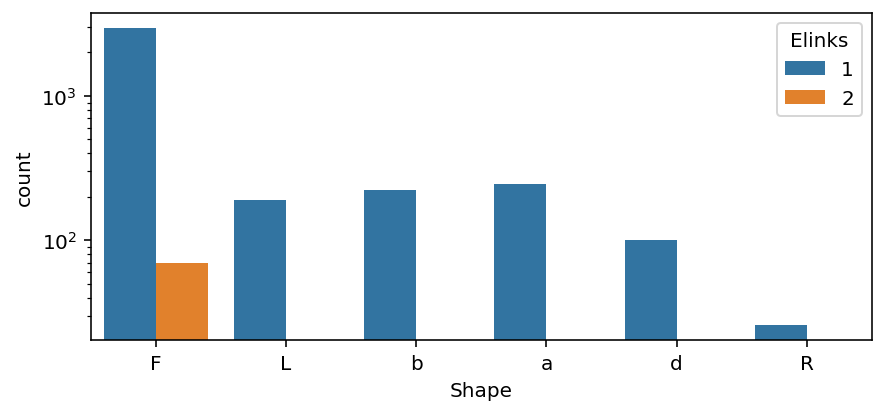

In [11]:
f, ax = plt.subplots(figsize=(7, 3))
sns.countplot(data=rates[ rates.Type=='LD' ], x='Shape', hue='Elinks').set_yscale('log')

In [12]:
import json

In [13]:
#y =json.loads("FeMappingV9.json")
#print(y["layer"])

In [345]:
json_file_path = "FeMappingV9.json"

with open(json_file_path, 'r') as j:
     contents = json.loads(j.read())

In [153]:
len(contents[0]["modules"])

3

In [16]:
rates

,Layer,U,V,Type,Shape,ADCHits,TOXHits,EvSize,EvSizeXCheck,Elinks
0,1,3,2,HD,F,155.139000,13.473600,151.8780,148,5
1,1,2,1,HD,d,109.195000,13.963700,107.4950,108,3
2,1,4,3,HD,F,83.525700,5.649590,96.1745,93,3
3,1,1,3,HD,F,155.107000,13.531100,151.8990,149,5
4,1,1,2,HD,d,109.327000,13.894200,107.5330,108,3
...,...,...,...,...,...,...,...,...,...,...
4846,50,15,7,Sci9,f,0.273679,0.175417,27.4491,27,5
4847,50,15,8,Sci9,F,0.276978,0.177971,27.4549,27,5
4848,50,15,9,Sci9,F,0.274512,0.169280,27.4438,27,5
4849,50,15,10,Sci9,f,0.274441,0.179390,27.4538,27,5


In [17]:
linkRates = pd.read_hdf('out/merged.h5', 'linkRates')
with pd.option_context('display.max_rows', None,):
    print(linkRates)

      DAQlpGBT     EvSize  Elinks  Layer          U          V       LUV  \
0           12  240.40570     7.0      1   4.666667   1.333333    332.00   
1           13  240.24240     7.0      1   3.333333   4.666667    314.00   
2           14  142.48750     5.0      1   6.500000   0.000000    360.00   
3           15  142.21120     5.0      1   6.500000   6.500000    366.50   
4           16  176.14950     6.0      1   7.000000   6.000000    374.00   
5           17  176.10000     6.0      1   1.000000   7.000000    279.00   
6           18  122.45580     4.0      1   7.500000   1.000000    377.00   
7           19  122.50560     4.0      1   6.500000   7.500000    367.50   
8           20  132.86450     4.0      1   7.500000   2.000000    378.00   
9           21  132.65810     4.0      1   5.500000   7.500000    351.50   
10          22  132.75350     4.0      1   7.500000   5.500000    381.50   
11          23  132.69990     4.0      1   2.000000   7.500000    295.50   
12          

In [18]:
rates.sort_values(by=["EvSize"], ascending=False)

,Layer,U,V,Type,Shape,ADCHits,TOXHits,EvSize,EvSizeXCheck,Elinks
374,5,2,2,HD,g,193.478000,58.612000,220.59400,222,5
371,5,2,0,HD,g,193.420000,58.579100,220.51600,222,5
565,7,2,0,HD,g,194.529000,53.222700,215.86400,216,5
568,7,2,2,HD,g,194.525000,53.150000,215.78700,216,5
186,3,2,2,HD,g,190.810000,50.287200,210.63100,213,5
...,...,...,...,...,...,...,...,...,...,...
4467,45,1,7,LD,a,0.035261,0.009347,9.04461,9,1
4495,46,8,2,LD,a,0.032583,0.008283,9.04085,9,1
4500,46,8,7,LD,a,0.030294,0.006864,9.03716,9,1
3490,34,10,12,LD,a,0.000000,0.000000,9.00000,9,1


In [19]:
for i in rates["EvSize"].values:
    if i==210.63100:
        print(True)

True


In [20]:
df = pd.DataFrame(contents)
df

,layer,MB,type,lpGBTs,modules
0,1,0,0,"[0, 1]","[{'u': 2, 'v': 0, 'elinks': [4, 0], 'shape': '..."
1,1,1,1,[2],"[{'u': 5, 'v': 0, 'elinks': [1], 'shape': 'F'}..."
2,1,2,0,[3],"[{'u': 4, 'v': 1, 'elinks': [2], 'shape': 'F'}..."
3,1,3,1,[4],"[{'u': 6, 'v': 1, 'elinks': [1], 'shape': 'F'}..."
4,1,4,0,[5],"[{'u': 3, 'v': 1, 'elinks': [3], 'shape': 'F'}..."
...,...,...,...,...,...
1276,50,0,11,[2163],"[{'u': 15, 'v': 7, 'elinks': [5], 'shape': 'f'}]"
1277,50,0,11,[2164],"[{'u': 15, 'v': 8, 'elinks': [5], 'shape': 'F'}]"
1278,50,0,11,[2165],"[{'u': 15, 'v': 9, 'elinks': [5], 'shape': 'F'}]"
1279,50,0,11,[2166],"[{'u': 15, 'v': 10, 'elinks': [5], 'shape': 'f'}]"


In [22]:
contents[0]

{'layer': 1,
 'MB': 0,
 'type': 0,
 'lpGBTs': [0, 1],
 'modules': [{'u': 2, 'v': 0, 'elinks': [4, 0], 'shape': 'g'},
  {'u': 3, 'v': 0, 'elinks': [3, 0], 'shape': 'F'},
  {'u': 4, 'v': 0, 'elinks': [0, 2], 'shape': 'F'}]}

In [23]:
with pd.option_context('display.max_rows', None,):
    print(rates.loc[rates["Layer"]==1])

      Layer   U   V  Type Shape     ADCHits    TOXHits     EvSize  \
0         1   3   2    HD     F  155.139000  13.473600  151.87800   
1         1   2   1    HD     d  109.195000  13.963700  107.49500   
2         1   4   3    HD     F   83.525700   5.649590   96.17450   
3         1   1   3    HD     F  155.107000  13.531100  151.89900   
4         1   1   2    HD     d  109.327000  13.894200  107.53300   
5         1   1   4    HD     F   83.346500   5.608940   96.00430   
6         1   3   0    HD     F  121.645000   9.351790  125.36500   
7         1   2   0    HD     g  178.111000  20.656100  171.29500   
8         1   4   0    HD     F   65.942400   4.211920   83.49390   
9         1   3   3    HD     F  121.656000   9.366370  125.37700   
10        1   2   2    HD     g  177.995000  20.631600  171.14300   
11        1   4   4    HD     F   65.831400   4.213590   83.42560   
12        1   4   2    HD     F   90.802700   6.242920  101.55900   
13        1   3   1    HD     F  1

In [24]:
len(contents)

1281

In [25]:
module_type = {
    0: 'HD',
    1: 'LD',
}
module_type.update(
    { i: f'Sci{i-2}' for i in range(2,12) }
)
pprint(module_type)
    

{0: 'HD',
 1: 'LD',
 2: 'Sci0',
 3: 'Sci1',
 4: 'Sci2',
 5: 'Sci3',
 6: 'Sci4',
 7: 'Sci5',
 8: 'Sci6',
 9: 'Sci7',
 10: 'Sci8',
 11: 'Sci9'}


In [26]:
for i in rates["Type"]:
    for k in module_type.values():
        if str(i)==str(k):
            
    

SyntaxError: unexpected EOF while parsing (<ipython-input-26-628c0a70d0fd>, line 5)

In [27]:
rates.loc[rates["Type"] == "HD", "Type"] = 0
rates.loc[rates["Type"] == "LD", "Type"] = 1
for i in range (2,12):
    rates.loc[rates["Type"] == f'Sci{i-2}', "Type"] = int(i)



In [307]:
contents[2]

{'layer': 1,
 'MB': 2,
 'type': 0,
 'lpGBTs': [3],
 'modules': [{'u': 4, 'v': 1, 'elinks': [2], 'shape': 'F'},
  {'u': 5, 'v': 1, 'elinks': [2], 'shape': 'F'},
  {'u': 5, 'v': 2, 'elinks': [2], 'shape': 'F'}]}

In [305]:
with pd.option_context('display.max_rows', None,):
    print(rates.loc[rates["Layer"]==1])

    Layer   U   V Type Shape    ADCHits   TOXHits    EvSize  EvSizeXCheck  \
0       1   3   2    0     F  155.13900  13.47360  151.8780           148   
1       1   2   1    0     d  109.19500  13.96370  107.4950           108   
2       1   4   3    0     F   83.52570   5.64959   96.1745            93   
3       1   1   3    0     F  155.10700  13.53110  151.8990           149   
4       1   1   2    0     d  109.32700  13.89420  107.5330           108   
5       1   1   4    0     F   83.34650   5.60894   96.0043            93   
6       1   3   0    0     F  121.64500   9.35179  125.3650           122   
7       1   2   0    0     g  178.11100  20.65610  171.2950           172   
8       1   4   0    0     F   65.94240   4.21192   83.4939            85   
9       1   3   3    0     F  121.65600   9.36637  125.3770           122   
10      1   2   2    0     g  177.99500  20.63160  171.1430           172   
11      1   4   4    0     F   65.83140   4.21359   83.4256            85   

In [31]:
len(contents)

1281

In [32]:
contents[0]["modules"][0]

{'u': 2, 'v': 0, 'elinks': [4, 0], 'shape': 'g'}

In [46]:
len(contents[0]["lpGBTs"])

2

In [44]:
link = pd.DataFrame({'layer': 1*len(contents[0]["modules"]),
 'MB': 0*len(contents[0]["modules"]),
 'type': 0*len(contents[0]["modules"]),
 'lpGBTs': [1]*len(contents[0]["modules"])})
link


,layer,MB,type,lpGBTs
0,3,0,0,1
1,3,0,0,1
2,3,0,0,1


In [40]:
link2 = pd.DataFrame(contents[0]["modules"][0])
link2

,u,v,elinks,shape
0,2,0,4,g
1,2,0,0,g


In [45]:
df=pd.concat([link,link2], axis=1)
df

,layer,MB,type,lpGBTs,u,v,elinks,shape
0,3,0,0,1,2.0,0.0,4.0,g
1,3,0,0,1,2.0,0.0,0.0,g
2,3,0,0,1,NaN,NaN,NaN,NaN


In [41]:
len(contents[0]["modules"])

3

# Single Link Connection Dataframe

In [148]:
column_names={"layer":[],"MB":[],"type":[],"lpGBTs":[],"u":[],"v":[],"elinks":[],"shape":[],"doubleDAQlpGBT":[]}
main_frame=pd.DataFrame(column_names)
main_frame

,layer,MB,type,lpGBTs,u,v,elinks,shape,doubleDAQlpGBT


In [149]:
for i in range(len(contents)):
    if len(contents[i]["lpGBTs"])==1:
        link = pd.DataFrame({'layer': [contents[i]["layer"]] *len(contents[i]["modules"]),
                 'MB': [contents[i]["MB"]]*len(contents[i]["modules"]),
                 'doubleDAQlpGBT': ["False"]*len(contents[i]["modules"]),
                 'type': [contents[i]["type"]]*len(contents[i]["modules"]),
                 'lpGBTs':[ contents[i]["lpGBTs"][0]]*len(contents[i]["modules"])})
        #for k in range(len(contents[i]["modules"])):
            #link2=pd.DataFrame(contents[i]["modules"][k])
        link2=pd.DataFrame(contents[i]["modules"])
        link=pd.concat([link,link2], axis=1)
    main_frame=pd.concat([main_frame,link], axis=0)
    

main_frame
        
    

,layer,MB,type,lpGBTs,u,v,elinks,shape,doubleDAQlpGBT
0,50.0,0.0,11.0,2167.0,15.0,11.0,[5],F,False
0,1.0,1.0,1.0,2.0,5.0,0.0,[1],F,False
1,1.0,1.0,1.0,2.0,6.0,0.0,[1],F,False
2,1.0,1.0,1.0,2.0,7.0,0.0,[1],F,False
3,1.0,1.0,1.0,2.0,8.0,0.0,[1],L,False
...,...,...,...,...,...,...,...,...,...
0,50.0,0.0,11.0,2163.0,15.0,7.0,[5],f,False
0,50.0,0.0,11.0,2164.0,15.0,8.0,[5],F,False
0,50.0,0.0,11.0,2165.0,15.0,9.0,[5],F,False
0,50.0,0.0,11.0,2166.0,15.0,10.0,[5],f,False


In [131]:
with pd.option_context('display.max_rows', None,):
    print(main_frame)

   layer     MB  type  lpGBTs     u     v    elinks shape doubleDAQlpGBT
0   50.0    0.0  11.0  [2167]  15.0  11.0       [5]     F            0.0
0    1.0    1.0   1.0     [2]   5.0   0.0       [1]     F          False
1    1.0    1.0   1.0     [2]   6.0   0.0       [1]     F          False
2    1.0    1.0   1.0     [2]   7.0   0.0       [1]     F          False
3    1.0    1.0   1.0     [2]   8.0   0.0       [1]     L          False
0    1.0    2.0   0.0     [3]   4.0   1.0       [2]     F          False
1    1.0    2.0   0.0     [3]   5.0   1.0       [2]     F          False
2    1.0    2.0   0.0     [3]   5.0   2.0       [2]     F          False
0    1.0    3.0   1.0     [4]   6.0   1.0       [1]     F          False
1    1.0    3.0   1.0     [4]   7.0   1.0       [1]     F          False
2    1.0    3.0   1.0     [4]   8.0   1.0       [1]     F          False
3    1.0    3.0   1.0     [4]   9.0   1.0       [1]     F          False
0    1.0    4.0   0.0     [5]   3.0   1.0       [3]

In [123]:
sum_= 0
for i in range(len(contents)):
    
    if len(contents[i]["lpGBTs"])==1:
        
        sum_+=len(contents[i]["modules"])

sum_                 

    
    

4609

In [122]:
for i in range(len(contents)):
    
    if len(contents[i]["lpGBTs"])==1:
        for k in range (len(contents[i]["modules"])):
            if len(contents[i]["modules"][k]["elinks"])==2:
                print("True")

# Now Double lpGBT part

In [138]:
for i in range(len(contents)):
    if len(contents[i]["lpGBTs"])==2:
        link = pd.DataFrame({'layer': [contents[i]["layer"]] *len(contents[i]["modules"]),
                 'MB': [contents[i]["MB"]]*len(contents[i]["modules"]),
                 'doubleDAQlpGBT': ["True"]*len(contents[i]["modules"]),
                 'type': [contents[i]["type"]]*len(contents[i]["modules"]),
                 'lpGBTs':[ contents[i]["lpGBTs"][0]]*len(contents[i]["modules"])})
        #for k in range(len(contents[i]["modules"])):
            #link2=pd.DataFrame(contents[i]["modules"][k])
        for k in range(len(contents[i]["modules"])):
            c=len(contents[i]["modules"])
            link2=pd.DataFrame({"u":[contents[i]["modules"][0]["u"]]*c,
                               "v":[contents[i]["modules"][0]["v"]]*c,
                              "elinks":[contents[i]["modules"][0]["elinks"]]*c,
                               "shape":[contents[i]["modules"][0]["shape"]]*c})
        #link2=pd.DataFrame(contents[i]["modules"])
        link=pd.concat([link,link2], axis=1)
    main_frame=pd.concat([main_frame,link], axis=0)
           # print(link)
main_frame

,layer,MB,type,lpGBTs,u,v,elinks,shape,doubleDAQlpGBT
0,50.0,0.0,11.0,2167.0,15.0,11.0,[5],F,False
0,1.0,1.0,1.0,2.0,5.0,0.0,[1],F,False
1,1.0,1.0,1.0,2.0,6.0,0.0,[1],F,False
2,1.0,1.0,1.0,2.0,7.0,0.0,[1],F,False
3,1.0,1.0,1.0,2.0,8.0,0.0,[1],L,False
...,...,...,...,...,...,...,...,...,...
3,17.0,112.0,0.0,494.0,1.0,2.0,"[2, 0]",d,True
0,17.0,112.0,0.0,494.0,1.0,2.0,"[2, 0]",d,True
1,17.0,112.0,0.0,494.0,1.0,2.0,"[2, 0]",d,True
2,17.0,112.0,0.0,494.0,1.0,2.0,"[2, 0]",d,True


In [129]:
contents[0]["modules"][0]

{'u': 2, 'v': 0, 'elinks': [4, 0], 'shape': 'g'}

In [139]:
with pd.option_context('display.max_rows', None,):
    print(main_frame)

   layer     MB  type  lpGBTs     u     v  elinks shape doubleDAQlpGBT
0   50.0    0.0  11.0  2167.0  15.0  11.0     [5]     F          False
0    1.0    1.0   1.0     2.0   5.0   0.0     [1]     F          False
1    1.0    1.0   1.0     2.0   6.0   0.0     [1]     F          False
2    1.0    1.0   1.0     2.0   7.0   0.0     [1]     F          False
3    1.0    1.0   1.0     2.0   8.0   0.0     [1]     L          False
0    1.0    2.0   0.0     3.0   4.0   1.0     [2]     F          False
1    1.0    2.0   0.0     3.0   5.0   1.0     [2]     F          False
2    1.0    2.0   0.0     3.0   5.0   2.0     [2]     F          False
0    1.0    3.0   1.0     4.0   6.0   1.0     [1]     F          False
1    1.0    3.0   1.0     4.0   7.0   1.0     [1]     F          False
2    1.0    3.0   1.0     4.0   8.0   1.0     [1]     F          False
3    1.0    3.0   1.0     4.0   9.0   1.0     [1]     F          False
0    1.0    4.0   0.0     5.0   3.0   1.0     [3]     F          False
1    1

# ADD EVENT-SİZE İNFORMATİONS

In [154]:
rates

,Layer,U,V,Type,Shape,ADCHits,TOXHits,EvSize,EvSizeXCheck,Elinks
0,1,3,2,0,F,155.139000,13.473600,151.8780,148,5
1,1,2,1,0,d,109.195000,13.963700,107.4950,108,3
2,1,4,3,0,F,83.525700,5.649590,96.1745,93,3
3,1,1,3,0,F,155.107000,13.531100,151.8990,149,5
4,1,1,2,0,d,109.327000,13.894200,107.5330,108,3
...,...,...,...,...,...,...,...,...,...,...
4846,50,15,7,11,f,0.273679,0.175417,27.4491,27,5
4847,50,15,8,11,F,0.276978,0.177971,27.4549,27,5
4848,50,15,9,11,F,0.274512,0.169280,27.4438,27,5
4849,50,15,10,11,f,0.274441,0.179390,27.4538,27,5


In [156]:
df_=pd.DataFrame(contents)
df_

,layer,MB,type,lpGBTs,modules
0,1,0,0,"[0, 1]","[{'u': 2, 'v': 0, 'elinks': [4, 0], 'shape': '..."
1,1,1,1,[2],"[{'u': 5, 'v': 0, 'elinks': [1], 'shape': 'F'}..."
2,1,2,0,[3],"[{'u': 4, 'v': 1, 'elinks': [2], 'shape': 'F'}..."
3,1,3,1,[4],"[{'u': 6, 'v': 1, 'elinks': [1], 'shape': 'F'}..."
4,1,4,0,[5],"[{'u': 3, 'v': 1, 'elinks': [3], 'shape': 'F'}..."
...,...,...,...,...,...
1276,50,0,11,[2163],"[{'u': 15, 'v': 7, 'elinks': [5], 'shape': 'f'}]"
1277,50,0,11,[2164],"[{'u': 15, 'v': 8, 'elinks': [5], 'shape': 'F'}]"
1278,50,0,11,[2165],"[{'u': 15, 'v': 9, 'elinks': [5], 'shape': 'F'}]"
1279,50,0,11,[2166],"[{'u': 15, 'v': 10, 'elinks': [5], 'shape': 'f'}]"


In [309]:
contents[0]
    

{'layer': 1,
 'MB': 0,
 'type': 0,
 'lpGBTs': [0, 1],
 'modules': [{'u': 2, 'v': 0, 'elinks': [4, 0], 'shape': 'g'},
  {'u': 3, 'v': 0, 'elinks': [3, 0], 'shape': 'F'},
  {'u': 4, 'v': 0, 'elinks': [0, 2], 'shape': 'F'}]}

In [296]:
with pd.option_context('display.max_rows', None,):
    print(rates)

      Layer   U   V Type Shape     ADCHits    TOXHits     EvSize  \
0         1   3   2    0     F  155.139000  13.473600  151.87800   
1         1   2   1    0     d  109.195000  13.963700  107.49500   
2         1   4   3    0     F   83.525700   5.649590   96.17450   
3         1   1   3    0     F  155.107000  13.531100  151.89900   
4         1   1   2    0     d  109.327000  13.894200  107.53300   
5         1   1   4    0     F   83.346500   5.608940   96.00430   
6         1   3   0    0     F  121.645000   9.351790  125.36500   
7         1   2   0    0     g  178.111000  20.656100  171.29500   
8         1   4   0    0     F   65.942400   4.211920   83.49390   
9         1   3   3    0     F  121.656000   9.366370  125.37700   
10        1   2   2    0     g  177.995000  20.631600  171.14300   
11        1   4   4    0     F   65.831400   4.213590   83.42560   
12        1   4   2    0     F   90.802700   6.242920  101.55900   
13        1   3   1    0     F  155.130000  13.4

In [192]:
double_info={}
eventsize_info={}

In [ ]:
for i in range(len(contents)):
    if len(contents[i]["lpGBTs"])==1:
        lpGBT= contents[i]["lpGBTs"][0]
        double_info["lpGBT"]="False"
        
(rates["V"]==int(contents[1]["modules"][0]["v"]))

In [293]:
contents[1]["modules"][0]["elinks"][0]

1

just one elink evsize

In [292]:
rates.loc[(rates["Layer"]==int(contents[1]["layer"]))& (rates["Type"]==int(contents[1]["type"]))&
          (rates["Shape"]==contents[1]["modules"][0]["shape"])&(rates["U"]==int(contents[1]["modules"][0]["u"]))
         &(rates["V"]==int(contents[1]["modules"][0]["v"]))&(rates["Elinks"]==int(contents[1]["modules"][0]["elinks"][0]))]#["EvSize"].item()

,Layer,U,V,Type,Shape,ADCHits,TOXHits,EvSize,EvSizeXCheck,Elinks


In [ ]:
7         1   2   0    0     g  178.111000  20.656100  171.29500 contents[0]

In [346]:
rates.loc[(rates["Layer"]==int(contents[0]["layer"]))& (rates["Type"]==int(contents[0]["type"]))&
          (rates["Shape"]==contents[0]["modules"][0]["shape"])&(rates["U"]==int(contents[0]["modules"][0]["u"]))
         &(rates["V"]==int(contents[0]["modules"][0]["v"]))]

,Layer,U,V,Type,Shape,ADCHits,TOXHits,EvSize,EvSizeXCheck,Elinks,lpGBT id
7,1,2,0,0,g,178.111,20.6561,171.295,172,5,NaN


In [287]:
rates.loc[(rates["Layer"]==int(contents[0]["layer"]))& (rates["Type"]==int(contents[0]["type"]))&
          (rates["Shape"]==contents[0]["modules"][0]["shape"])&(rates["U"]==int(contents[0]["modules"][0]["u"]))
         &(rates["V"]==int(contents[0]["modules"][0]["v"]))&]#["EvSize"].item()

,Layer,U,V,Type,Shape,ADCHits,TOXHits,EvSize,EvSizeXCheck,Elinks
7,1,2,0,0,g,178.111,20.6561,171.295,172,5


In [233]:
elinks=[]

In [281]:
def get_Event_Size_lpGBts_(i):
    sum_rate=0
    for k in range(len(contents[i]["modules"])):
        rate=rates.loc[(rates["Layer"]==int(contents[i]["layer"]))& (rates["Type"]==int(contents[i]["type"]))&
              (rates["Shape"]==contents[i]["modules"][k]["shape"])&(rates["U"]==int(contents[i]["modules"][k]["u"]))
             &(rates["V"]==int(contents[i]["modules"][k]["v"]))]["EvSize"].item()
        sum_rate+=rate
    return sum_rate
        #return rate
    

In [283]:
get_Event_Size_lpGBTs_(2)

240.40570000000002

In [341]:
def update_contents():
    for i in range(24,len(contents)):
        event_size=get_Event_Size_lpGBTs_(i)
        #print(event_size)
        contents[i].pop("modules")
        contents[i]["eventSize"]=event_size
        lpgbt_id=contents[i]["lpGBTs"][0]
        contents[i]["lpgbt_id"]=lpgbt_id
    return contents
        

In [342]:
update_contents()


KeyError: 'modules'

In [329]:
contents[0].pop("modules")
contents[0]

{'layer': 1, 'MB': 0, 'type': 0, 'lpGBTs': [0, 1]}

In [343]:
contents

[{'layer': 1, 'MB': 0, 'type': 0, 'lpGBTs': [0, 1]},
 {'layer': 1,
  'MB': 1,
  'type': 1,
  'lpGBTs': [2],
  'modules': [{'u': 5, 'v': 0, 'elinks': [1], 'shape': 'F'},
   {'u': 6, 'v': 0, 'elinks': [1], 'shape': 'F'},
   {'u': 7, 'v': 0, 'elinks': [1], 'shape': 'F'},
   {'u': 8, 'v': 0, 'elinks': [1], 'shape': 'L'}]},
 {'layer': 1,
  'MB': 2,
  'type': 0,
  'lpGBTs': [3],
  'modules': [{'u': 4, 'v': 1, 'elinks': [2], 'shape': 'F'},
   {'u': 5, 'v': 1, 'elinks': [2], 'shape': 'F'},
   {'u': 5, 'v': 2, 'elinks': [2], 'shape': 'F'}]},
 {'layer': 1,
  'MB': 3,
  'type': 1,
  'lpGBTs': [4],
  'modules': [{'u': 6, 'v': 1, 'elinks': [1], 'shape': 'F'},
   {'u': 7, 'v': 1, 'elinks': [1], 'shape': 'F'},
   {'u': 8, 'v': 1, 'elinks': [1], 'shape': 'F'},
   {'u': 9, 'v': 1, 'elinks': [1], 'shape': 'F'}]},
 {'layer': 1,
  'MB': 4,
  'type': 0,
  'lpGBTs': [5],
  'eventSize': 326.8147,
  'lpgbt_id': 5},
 {'layer': 1,
  'MB': 5,
  'type': 0,
  'lpGBTs': [6, 7],
  'eventSize': 0,
  'lpgbt_id': 6},
 

In [ ]:
def get_Event_Size_lpGBTs_(i):
    sum_rate=0
    if len(contents[i]["lpGBTs"])==1:
        for k in range(len(contents[i]["modules"])):
            rate=rates.loc[(rates["Layer"]==int(contents[i]["layer"]))& (rates["Type"]==int(contents[i]["type"]))&
                    (rates["Shape"]==contents[i]["modules"][k]["shape"])&(rates["U"]==int(contents[i]["modules"][k]["u"]))
                     &(rates["V"]==int(contents[i]["modules"][k]["v"]))]["EvSize"].item()
            sum_rate+=rate
            
    else:
        for k in range(len(contents[i]["modules"])):
            rate=rates.loc[(rates["Layer"]==int(contents[i]["layer"]))& (rates["Type"]==int(contents[i]["type"]))&
                    (rates["Shape"]==contents[i]["modules"][k]["shape"])&(rates["U"]==int(contents[i]["modules"][k]["u"]))
                     &(rates["V"]==int(contents[i]["modules"][k]["v"]))]["EvSize"].item()
            sum_rate+=rate
        
    return sum_rate
        #return rate